# A2C trade

In this notebook a fully connected Actor Critic model is trained on the crude oil daily dataset, enriched with the various tecnical indicators and the crude oil implied volatility index `OVX`.

The importance of **implied volatility** for market participants stems from the fact that it is one of the only data that is **forward-looking**. This is because market participants always trade contracts with an expiration date later in time.

The goal of this notebook is to see how (if it is possible) a **A2C** trading agent can leverage this kind of data to learn a profitable trading strategy.


In [ ]:
#@title **Install externals libraries** {display-mode:'form'}
!pip install stable-baselines3[extra] quantstats --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 8.1 MB/s 
     |████████████████████████████████| 41 kB 10.9 MB/s 
     |████████████████████████████████| 62 kB 46.6 MB/s 
     |████████████████████████████████| 6.4 MB 62.3 MB/s 
     |████████████████████████████████| 1.5 MB 61.3 MB/s 
     |████████████████████████████████| 1.6 MB 51.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=060b8c44e10cabffe2954c79ef765e13e6fc87f183b74127abf8121d2b932036
  Stored in directory: /tmp/pip-ephem-wheel-cache-18ym8tbp/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=fc80be3132b28b8948529b5596841b1

In [ ]:
#@title **Imports** {display-mode: 'form'}

import numpy as np
import pandas as pd
import quantstats as qs

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from gym_anytrading2.envs import FuturesEnv

from stable_baselines3 import A2C

# Training

Only 80% of the total data is used during the training phase. That’s because we want to avoid the model simply memorizing the dataset (overfitting) and obtaining a model that is generalized well in all market situations.

The A2C model is a fully connected neural network with 4 layers with 256, 128, 128, 64 neurson respectvely, the neural network will be given as input the daily data of the previous month (21 days).

In [ ]:
def add_cyclical_features(df):
    df['date'] = pd.to_datetime(df.index.copy(), format='%Y-%m-%d')
    df['day_sin'] = df['date'].apply(lambda x: np.sin(x.day * (2. * np.pi / 30)))
    df['day_cos'] = df['date'].apply(lambda x: np.cos(x.day * (2. * np.pi / 30)))
    df['month_sin'] = df['date'].apply(lambda x: np.sin(x.month * (2. * np.pi / 12)))
    df['month_cos'] = df['date'].apply(lambda x: np.cos(x.month * (2. * np.pi / 12)))
    df = df.drop('date', axis=1)
    return df

In [ ]:
cl_df = pd.read_csv('/content/mydrive/MyDrive/Datasets/trading/CL_daily_adj.csv', parse_dates=True)
cl_df = cl_df.set_index('Date')
cl_df = add_cyclical_features(cl_df)

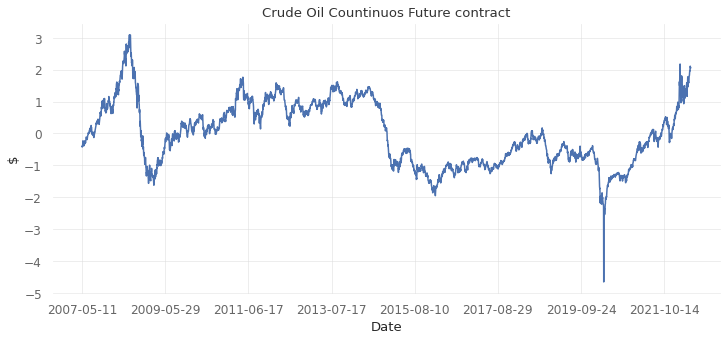

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
cl_df.close.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('$')
ax.set_title('Crude Oil Countinuos Future contract')
plt.show()

In [ ]:
window_size = 21
training_portion = 0.8
episodes = 250

train_cl_df = cl_df[0:int(np.floor(len(cl_df) * training_portion))]
test_cl_df = cl_df[int(np.floor(len(cl_df) * training_portion)):]

env = FuturesEnv(df=train_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(train_cl_df)))

In [ ]:
policy_kwargs = {'net_arch':[256, 128, 128, 64]}
model = A2C("MlpPolicy", 
            env, 
            verbose=1,
            seed=0,
            policy_kwargs=policy_kwargs
            )
model.learn(total_timesteps=episodes*len(train_cl_df))

Output streaming troncato alle ultime 5000 righe.
|    value_loss         | 10.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.91e+03 |
|    ep_rew_mean        | 1.04e+03 |
| time/                 |          |
|    fps                | 482      |
|    iterations         | 153700   |
|    time_elapsed       | 1593     |
|    total_timesteps    | 768500   |
| train/                |          |
|    entropy_loss       | -0.0932  |
|    explained_variance | -0.607   |
|    learning_rate      | 0.0007   |
|    n_updates          | 153699   |
|    policy_loss        | -0.0365  |
|    value_loss         | 5.46     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.91e+03 |
|    ep_rew_mean        | 1.04e+03 |
| time/                 |          |
|    fps                | 482      |
|    iterations         |

# Testing Results

Now that the model has been trained, let’s test its performance on the testing data (out of sample data).



In [ ]:
testing_env = FuturesEnv(df=test_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(test_cl_df)))

In [ ]:
obs = testing_env.reset()
i = 0

for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = testing_env.step(action)

    print(f'step: {i}, reward: {rewards}, account_value: {testing_env.get_account_value()}, action: {action}, position: {info["position"]}')

    if dones:
      break

    i += 1

step: 0, reward: 0, account_value: 1000000, action: 1, position: -1
step: 1, reward: -0.05091026213379323, account_value: 1000000, action: 1, position: -1
step: 2, reward: -0.19451114426483523, account_value: 1000000, action: 1, position: -1
step: 3, reward: -0.2502566252767778, account_value: 1000000, action: 1, position: -1
step: 4, reward: -0.3344001866922833, account_value: 1000000, action: 1, position: -1
step: 5, reward: -0.31401870592553166, account_value: 1000000, action: 1, position: -1
step: 6, reward: -0.2857654423578625, account_value: 1000000, action: 1, position: -1
step: 7, reward: -0.25090189532880725, account_value: 1000000, action: 1, position: -1
step: 8, reward: -0.30672489957018245, account_value: 1000000, action: 1, position: -1
step: 9, reward: -0.2981476706445037, account_value: 1000000, action: 1, position: -1
step: 10, reward: -0.2870105873892981, account_value: 1000000, action: 1, position: -1
step: 11, reward: -0.24443038107836637, account_value: 1000000, ac

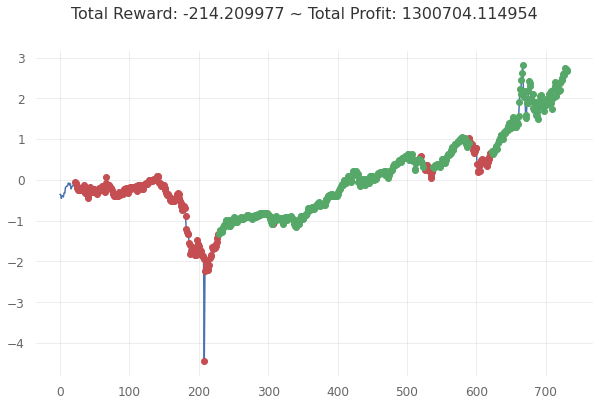

In [ ]:
plt.cla()
testing_env.render_all()

## Testing period statistics

Let's see how the trading strategy learned in the training phase has performed on data that the model has never seen before. 

[Performance Metrics]



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


                           Strategy
-------------------------  ----------
Start Period               2019-07-15
End Period                 2022-06-13
Risk-Free Rate             0.0%
Time in Market             2.0%

Cumulative Return          30.07%
CAGR﹪                     9.44%

Sharpe                     1.21
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.2
Sortino                    25.06
Smart Sortino              24.92
Sortino/√2                 17.72
Smart Sortino/√2           17.62
Omega                      31.38

Max Drawdown               -0.57%
Longest DD Days            315
Volatility (ann.)          7.96%
Calmar                     16.68
Skew                       14.84
Kurtosis                   233.78

Expected Daily %           0.04%
Expected Monthly %         0.73%
Expected Yearly %          6.79%
Kelly Criterion            70.41%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.79%
Expected Shortfall (cVaR)  -0.79%

Max Consecutive Wins  

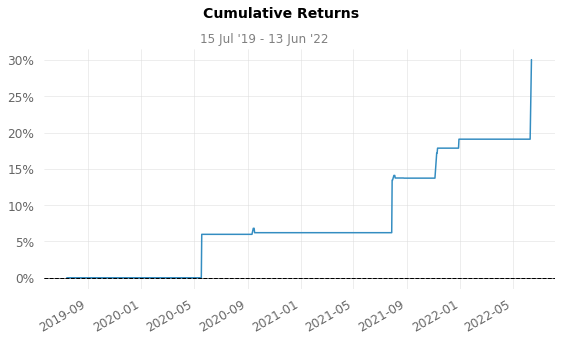

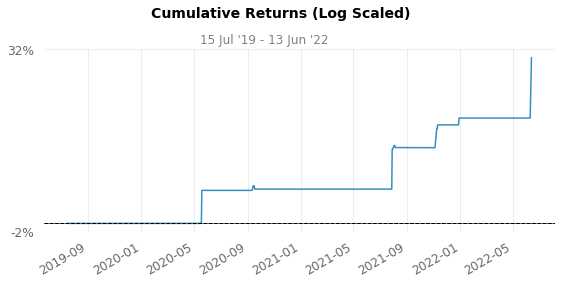

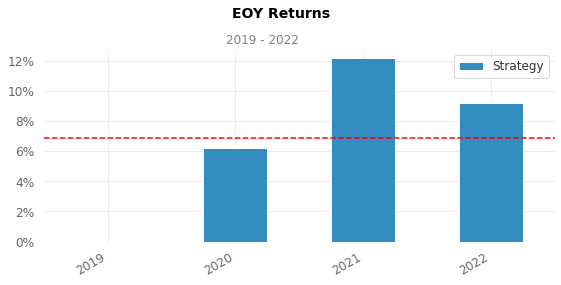

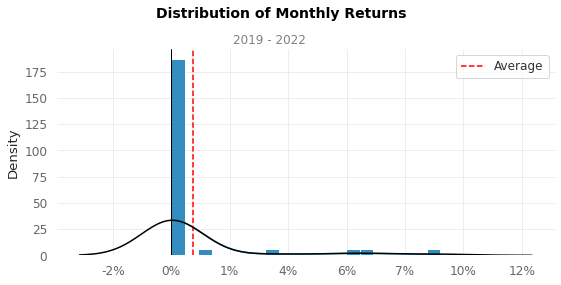

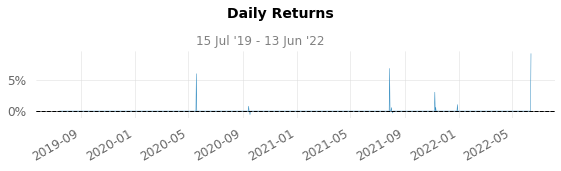

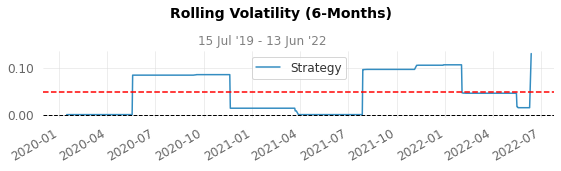

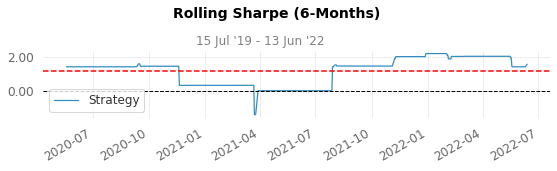

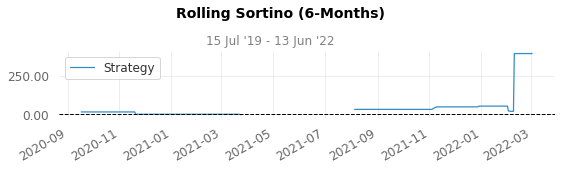

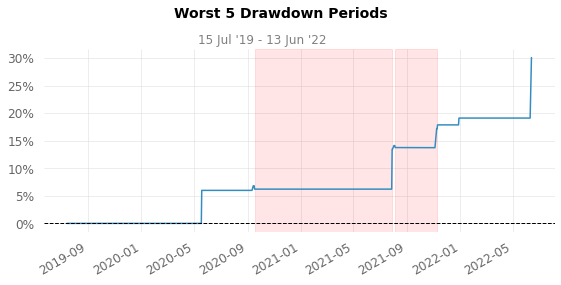

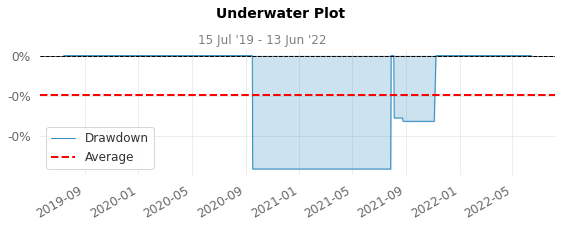

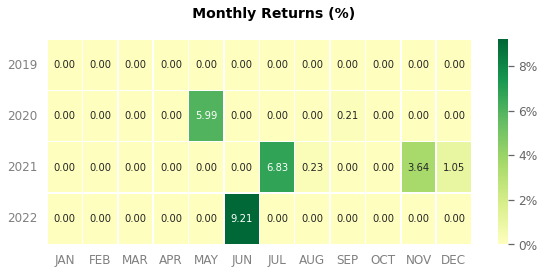

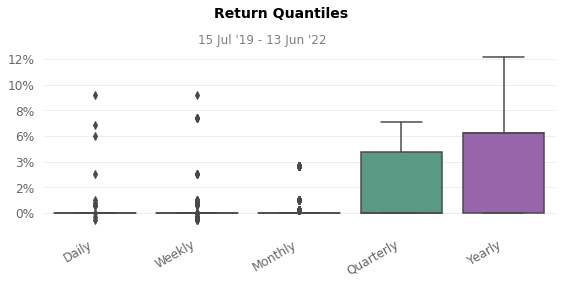

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(testing_env.history['total_profit'], index=test_cl_df.index[22:])
net_worth.index = pd.to_datetime(net_worth.index)

returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns, match_dates=True)